In [617]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

# data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [618]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [619]:
import socket
myHostName = socket.gethostname()
print(myHostName)

Tarins-MacBook.local


In [620]:
device = torch.device("mps")

# number of signals per iteration
batch_size = 32

### Dataloader

In [621]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv, parameter):
        self.parameters = pd.read_csv(parameters_csv)
        self.signals = pd.read_csv(signals_csv).astype('float32')

        # remove unusual parameters and corresponding signals
        keep_signals_idx = np.array(self.parameters[self.parameters['beta1_IC_b'] > 0].index)
        self.parameters = self.parameters.iloc[keep_signals_idx,:]
        self.signals = self.signals.iloc[:,keep_signals_idx]

        # process beta_ic_b parameter
        ranges = [0, 0.06, 0.17, 1]
        labels = [0, 1, 2]
        num_classes = len(labels)
        self.beta = self.parameters['beta1_IC_b']
        self.beta = pd.cut(self.beta, bins=ranges, labels=labels).astype('int')
        self.beta = self.beta.values
        self.beta = np.eye(num_classes)[self.beta]
        # self.beta = np.reshape(self.beta, (self.beta.shape[0], self.beta.shape[1], 1)).astype('float32')

        # bin selected labels according to literature or equal-freq binning where appropriate
        if (parameter == 'beta1_IC_b'):  
            self.parameters = self.beta
        elif (parameter == 'A(km)'):
            self.parameters = self.parameters[parameter]
            num_classes = 5
            replacement = {300: 0, 467: 1, 634: 2, 1268: 3, 10000: 4}
            self.parameters = self.parameters.replace(replacement)
            self.parameters = self.parameters.values
            self.parameters = np.eye(num_classes)[self.parameters]
        elif (parameter == 'omega_0(rad|s)'):
            self.parameters = self.parameters[parameter]
            num_classes = 5
            dummy, bin_boundaries = pd.qcut(self.parameters, q= num_classes, retbins=True, duplicates='drop')
            self.parameters = self.parameters.values
            self.parameters = np.digitize(self.parameters,bins=bin_boundaries[1:num_classes])
            self.parameters = np.eye(num_classes)[self.parameters]
        elif (parameter == 'Ye_c_b'):
            self.parameters = self.parameters[parameter]
            num_classes = 5
            dummy, bin_boundaries = pd.qcut(self.parameters, q=num_classes, retbins=True, duplicates='drop')
            self.parameters = self.parameters.values
            self.parameters = np.digitize(self.parameters,bins=bin_boundaries[1:num_classes])
            self.parameters = np.eye(num_classes)[self.parameters]
        

        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1])).astype('float32')

        self.signals = self.signals.values
        self.original_signals = self.signals
        self.augmented_signals = np.empty(shape = (256, 0)).astype('float32')

        ### signal manipulation section ###        
        temp_signals = np.empty(shape = (256, 0)).astype('float32')
        for i in range(0, self.signals.shape[1]):
            signal = self.signals[:, i]
            signal = signal.reshape(1, -1)

            cut_signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]

            temp_signals = np.insert(temp_signals, temp_signals.shape[1], cut_signal, axis=1)

        
        self.signals = temp_signals
        ### end signal manipulation section ###

    ### augmentation methods ###
    def jittering_augmentation(self, signal):
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
        return jittered_signal
    
    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 50, 1)
        shifted_signal = np.roll(signal, int(shift))
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.5, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)
        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  np.random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 53

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal
        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        while self.signals.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, 1684)
            signal_1 = self.signals[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            ### mixture augmentation only ###
            # find the class of signal_1 (assuming class is a column in self.parameters)
            beta_class_of_signal_1 = np.argmax(self.beta[idx_1, :])
            # sample only from the same class for signal_2 and make sure it's not the same as signal_1
            candidate_indices = [x for x in range(0, 1684) if x != idx_1 and np.argmax(self.beta[x, :]) == beta_class_of_signal_1]
            idx_2 = np.random.choice(candidate_indices)
            signal_2 = self.signals[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            # augmented_signal = self.scale_augmentation(signal_1)
            augmented_signal = signal_1
            # augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_signals = np.insert(self.augmented_signals, self.augmented_signals.shape[1], augmented_signal, axis=1)
            self.signals = np.insert(self.signals, self.signals.shape[1], augmented_signal, axis=1)

            # just copy parameters for now
            augmented_parameter = self.parameters[idx_1, :]

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print("Signal Dataset Size after Data Augmentation: ", self.signals.shape)
        print("Parameter Dataset Size after Data Augmentation: ", self.parameters.shape)

    ### end augmentation methods ###
    # def set_test_samples(self, test_sample_idx):
    #     self.signals_test_samples = self.signals[:, test_sample_idx]
    #     self.parameters_test_sample = self.parameters[test_sample_idx,:]

    ### overloads ###
    def __len__(self):
        return self.augmented_signals.shape[1]

    def __getitem__(self, idx):
        signal = self.augmented_signals[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.augmented_parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        return signal, parameter

In [622]:
ndf = 64
nc = 1

In [623]:
class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2)
            )

            self.fc_class = nn.Sequential(
                nn.LazyLinear(dataset.parameters.shape[1]),
                nn.LogSoftmax(dim=1)
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)
            x = self.fc_class(x)
            return x

### Beta1_IC_b Evaluation

In [624]:
parameter = 'beta1_IC_b'
dataset = GWDataset("../data/richers_1764.csv", "../data/richers_1764_parameters.csv", parameter)
dataset.augmentation(6000)

beta_class_of_signal_1:  1
beta_class_of_signal_1:  0
beta_class_of_signal_1:  0
beta_class_of_signal_1:  2
beta_class_of_signal_1:  1
beta_class_of_signal_1:  1
beta_class_of_signal_1:  0
beta_class_of_signal_1:  1
beta_class_of_signal_1:  2
beta_class_of_signal_1:  0
beta_class_of_signal_1:  0
beta_class_of_signal_1:  0
beta_class_of_signal_1:  1
beta_class_of_signal_1:  1
beta_class_of_signal_1:  0
beta_class_of_signal_1:  0
beta_class_of_signal_1:  1
beta_class_of_signal_1:  0
beta_class_of_signal_1:  2
beta_class_of_signal_1:  0
beta_class_of_signal_1:  1
beta_class_of_signal_1:  1
beta_class_of_signal_1:  1
beta_class_of_signal_1:  0
beta_class_of_signal_1:  2
beta_class_of_signal_1:  0
beta_class_of_signal_1:  0
beta_class_of_signal_1:  1
beta_class_of_signal_1:  1
beta_class_of_signal_1:  1
beta_class_of_signal_1:  0
beta_class_of_signal_1:  0
beta_class_of_signal_1:  1
beta_class_of_signal_1:  2
beta_class_of_signal_1:  0
beta_class_of_signal_1:  1
beta_class_of_signal_1:  0
b

KeyboardInterrupt: 

In [ ]:
net = torch.load("../models/rotational_speed_signals.pt").to(device)
net.eval()

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2,

In [ ]:
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

cum_true_indices = torch.Tensor().to(device, dtype=torch.float32)
cum_predicted_indices = torch.Tensor().to(device, dtype=torch.float32)

correct_classifications = 0
total_samples = 0

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y = y.squeeze(1)

        y_hat = net(x)

        true_indices = torch.argmax(y, dim=1)
        predicted_indices = torch.argmax(y_hat, dim=1)

        correct_classifications += torch.sum(true_indices == predicted_indices).item()
        total_samples += true_indices.size(0)

        cum_true_indices = torch.cat([cum_true_indices, true_indices], dim=0)
        cum_predicted_indices = torch.cat([cum_predicted_indices, predicted_indices], dim=0)

cumulative_proportion_correct = correct_classifications / total_samples
print("Cumulative Proportion of Correct Classifications: {:.2f}%".format(cumulative_proportion_correct * 100))

Cumulative Proportion of Correct Classifications: 92.10%


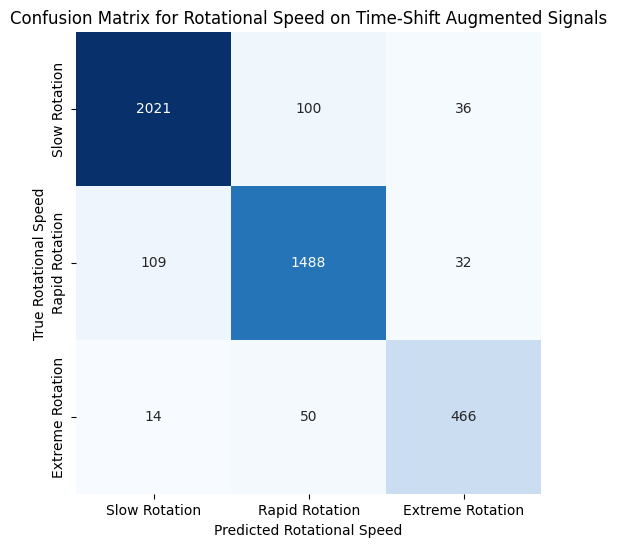

In [ ]:
if parameter == 'beta1_IC_b':
    display_labels = ["Slow Rotation", "Rapid Rotation", "Extreme Rotation"]
elif parameter == 'A(km)':
    display_labels = [300, 467, 634, 1268, 10000]
elif parameter == 'omega_0(rad|s)':
    display_labels = ['0.5-2.0', '2.0-4.0', '4.0-6.0', '6.0-9.0', '9.0-15.5']
elif parameter == 'Ye_c_b':
    display_labels = ['0.247-0.267', '0.267-0.288', '0.288-0.309', '0.309-0.330', '0.330-0.351']

confusion_matrix = metrics.confusion_matrix(cum_true_indices.cpu(), cum_predicted_indices.cpu())

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix.T, annot=True, fmt='d', cmap='Blues', xticklabels=display_labels, yticklabels=display_labels, cbar=False)

plt.title('Confusion Matrix for Rotational Speed on Time-Shift Augmented Signals')
plt.ylabel('True Rotational Speed')
plt.xlabel('Predicted Rotational Speed')
# plt.savefig('../plots/rotational_speed_time-shift_confusion_matrix.png')
plt.show()

### Omega_0 Evaluation

In [ ]:
parameter = 'omega_0(rad|s)'
dataset = GWDataset("../data/richers_1764.csv", "../data/richers_1764_parameters.csv", parameter)
dataset.augmentation(6000)

Signal Dataset Size after Data Augmentation:  (256, 6000)
Parameter Dataset Size after Data Augmentation:  (6000, 5)


In [ ]:
net = torch.load("../models/omega_0_signals.pt").to(device)
net.eval()

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2,

In [ ]:
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

cum_true_indices = torch.Tensor().to(device, dtype=torch.float32)
cum_predicted_indices = torch.Tensor().to(device, dtype=torch.float32)

correct_classifications = 0
total_samples = 0

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y = y.squeeze(1)

        y_hat = net(x)

        true_indices = torch.argmax(y, dim=1)
        predicted_indices = torch.argmax(y_hat, dim=1)

        correct_classifications += torch.sum(true_indices == predicted_indices).item()
        total_samples += true_indices.size(0)

        cum_true_indices = torch.cat([cum_true_indices, true_indices], dim=0)
        cum_predicted_indices = torch.cat([cum_predicted_indices, predicted_indices], dim=0)

cumulative_proportion_correct = correct_classifications / total_samples
print("Cumulative Proportion of Correct Classifications: {:.2f}%".format(cumulative_proportion_correct * 100))

Cumulative Proportion of Correct Classifications: 86.10%


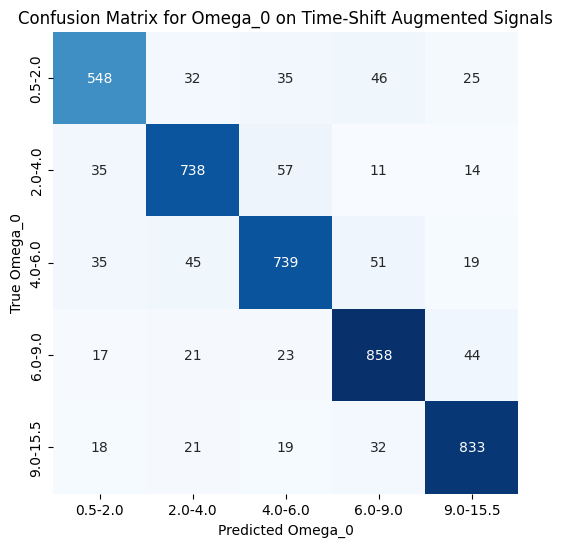

In [ ]:
if parameter == 'beta1_IC_b':
    display_labels = ["Slow Rotation", "Rapid Rotation", "Extreme Rotation"]
elif parameter == 'A(km)':
    display_labels = [300, 467, 634, 1268, 10000]
elif parameter == 'omega_0(rad|s)':
    display_labels = ['0.5-2.0', '2.0-4.0', '4.0-6.0', '6.0-9.0', '9.0-15.5']
elif parameter == 'Ye_c_b':
    display_labels = ['0.247-0.267', '0.267-0.288', '0.288-0.309', '0.309-0.330', '0.330-0.351']

confusion_matrix = metrics.confusion_matrix(cum_true_indices.cpu(), cum_predicted_indices.cpu())

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix.T, annot=True, fmt='d', cmap='Blues', xticklabels=display_labels, yticklabels=display_labels, cbar=False)

plt.title('Confusion Matrix for Omega_0 on Time-Shift Augmented Signals')
plt.ylabel('True Omega_0')
plt.xlabel('Predicted Omega_0')
# plt.savefig('../plots/omega_0_time-shift_confusion_matrix.png')
plt.show()

### A Evaluation

In [ ]:
parameter = 'A(km)'
dataset = GWDataset("../data/richers_1764.csv", "../data/richers_1764_parameters.csv", parameter)
dataset.augmentation(6000)

Signal Dataset Size after Data Augmentation:  (256, 6000)
Parameter Dataset Size after Data Augmentation:  (6000, 5)


In [ ]:
net = torch.load("../models/A_signals.pt").to(device)
net.eval()

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2,

In [ ]:
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

cum_true_indices = torch.Tensor().to(device, dtype=torch.float32)
cum_predicted_indices = torch.Tensor().to(device, dtype=torch.float32)

correct_classifications = 0
total_samples = 0

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y = y.squeeze(1)

        y_hat = net(x)

        true_indices = torch.argmax(y, dim=1)
        predicted_indices = torch.argmax(y_hat, dim=1)

        correct_classifications += torch.sum(true_indices == predicted_indices).item()
        total_samples += true_indices.size(0)

        cum_true_indices = torch.cat([cum_true_indices, true_indices], dim=0)
        cum_predicted_indices = torch.cat([cum_predicted_indices, predicted_indices], dim=0)

cumulative_proportion_correct = correct_classifications / total_samples
print("Cumulative Proportion of Correct Classifications: {:.2f}%".format(cumulative_proportion_correct * 100))

Cumulative Proportion of Correct Classifications: 91.47%


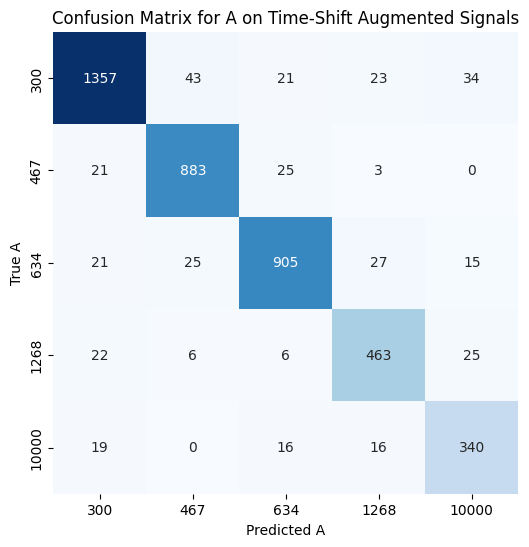

In [ ]:
if parameter == 'beta1_IC_b':
    display_labels = ["Slow Rotation", "Rapid Rotation", "Extreme Rotation"]
elif parameter == 'A(km)':
    display_labels = [300, 467, 634, 1268, 10000]
elif parameter == 'omega_0(rad|s)':
    display_labels = ['0.5-2.0', '2.0-4.0', '4.0-6.0', '6.0-9.0', '9.0-15.5']
elif parameter == 'Ye_c_b':
    display_labels = ['0.247-0.267', '0.267-0.288', '0.288-0.309', '0.309-0.330', '0.330-0.351']

confusion_matrix = metrics.confusion_matrix(cum_true_indices.cpu(), cum_predicted_indices.cpu())

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix.T, annot=True, fmt='d', cmap='Blues', xticklabels=display_labels, yticklabels=display_labels, cbar=False)

plt.title('Confusion Matrix for A on Time-Shift Augmented Signals')
plt.ylabel('True A')
plt.xlabel('Predicted A')
# plt.savefig('../plots/A_time-shift_confusion_matrix.png')
plt.show()

### Ye_c_b

In [ ]:
parameter = 'Ye_c_b'
dataset = GWDataset("../data/richers_1764.csv", "../data/richers_1764_parameters.csv", parameter)
dataset.augmentation(6000)

Signal Dataset Size after Data Augmentation:  (256, 6000)
Parameter Dataset Size after Data Augmentation:  (6000, 5)


In [ ]:
net = torch.load("../models/Ye_c_b_signals.pt").to(device)
net.eval()

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2,

In [ ]:
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

cum_true_indices = torch.Tensor().to(device, dtype=torch.float32)
cum_predicted_indices = torch.Tensor().to(device, dtype=torch.float32)

correct_classifications = 0
total_samples = 0

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y = y.squeeze(1)

        y_hat = net(x)

        true_indices = torch.argmax(y, dim=1)
        predicted_indices = torch.argmax(y_hat, dim=1)

        correct_classifications += torch.sum(true_indices == predicted_indices).item()
        total_samples += true_indices.size(0)

        cum_true_indices = torch.cat([cum_true_indices, true_indices], dim=0)
        cum_predicted_indices = torch.cat([cum_predicted_indices, predicted_indices], dim=0)

cumulative_proportion_correct = correct_classifications / total_samples
print("Cumulative Proportion of Correct Classifications: {:.2f}%".format(cumulative_proportion_correct * 100))

Cumulative Proportion of Correct Classifications: 94.69%


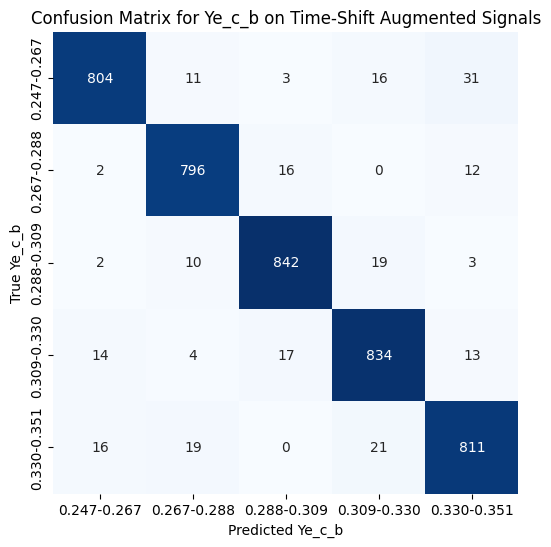

In [ ]:
if parameter == 'beta1_IC_b':
    display_labels = ["Slow Rotation", "Rapid Rotation", "Extreme Rotation"]
elif parameter == 'A(km)':
    display_labels = [300, 467, 634, 1268, 10000]
elif parameter == 'omega_0(rad|s)':
    display_labels = ['0.5-2.0', '2.0-4.0', '4.0-6.0', '6.0-9.0', '9.0-15.5']
elif parameter == 'Ye_c_b':
    display_labels = ['0.247-0.267', '0.267-0.288', '0.288-0.309', '0.309-0.330', '0.330-0.351']

confusion_matrix = metrics.confusion_matrix(cum_true_indices.cpu(), cum_predicted_indices.cpu())

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix.T, annot=True, fmt='d', cmap='Blues', xticklabels=display_labels, yticklabels=display_labels, cbar=False)

plt.title('Confusion Matrix for Ye_c_b on Time-Shift Augmented Signals')
plt.ylabel('True Ye_c_b')
plt.xlabel('Predicted Ye_c_b')
# plt.savefig('../plots/Ye_c_b_time-shift_confusion_matrix.png')
plt.show()